In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from sklearn.mixture import GaussianMixture 
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
!pwd

/home/mingyi/Dropbox/DOE_Anomaly_Detection


In [3]:
path = '/home/mingyi/Dropbox/DOE_Anomaly_Detection/'

In [4]:
def GMMBIC(df):
#     station = 'JFK'
#     df = pd.read_csv(path + station + 'HybridModelresult.csv',parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df.date.dt.date
    df = df.groupby(['date']).sum()
    matrix = df.values
    bic = []
    for ncomp in range(2,6):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [5]:
def anomalyDetection(y,ncom,pval,iterN=20):
    #index of regular (non-outlier points)
    if len(y.shape) == 1:
        y = np.array(y).reshape(-1,1)
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=ncom,n_init=100,max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
#         print('Iteration {}'.format(i+1))  
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
#         print(Lthres)
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
#             print('Convergence in {} iterations'.format(i+1))
            break
    return l < Lthres

In [6]:
def getEvents(event):
    df_events = pd.read_csv(event+'.csv', encoding = "ISO-8859-1", parse_dates=['Date'], infer_datetime_format=True)

    # dataframe for events
    df_finalEvents =  df_events[['Date', 'Type']]
    
    df_finalEvents['National Holiday'] = False
    df_finalEvents['Extreme Weather'] = False
#     df_finalEvents['Culture Event'] = False
    df_finalEvents['Airport Event'] = False
    df_finalEvents.loc[df_finalEvents['Type'] == 'National Holiday', 'National Holiday'] = True
    df_finalEvents.loc[df_finalEvents['Type'] == 'Extreme Weather', 'Extreme Weather'] = True
#     df_finalEvents.loc[df_finalEvents['Type'] == 'Culture Event', 'Culture Event'] = True
    df_finalEvents.loc[df_finalEvents['Type'] == 'Airport Event', 'Airport Event'] = True

    df_finalEvents = df_finalEvents.groupby(['Date']).sum()
    df_finalEvents['Anomaly'] = True
    df_finalEvents.reset_index(inplace=True)
#     print(df_events)
    return df_finalEvents

In [26]:
def AnomalyDetectionPipeline(data,compMin,compMax,outputfilename):
#     data = pd.read_csv(path + "OutputForPCA_features_v2/DailyAggreagtedPC10Resid.csv",parse_dates=['date'])
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['date'] = data.date.dt.date
    matrix = data.drop(columns=['date']).values
#     EventsDF = getEvents(event)
    date = data.date.to_frame().rename(columns={'date':'Date'})
    threresult = {}
#     EventsDF['Date'] = EventsDF['Date'].astype('str')
    date['Date'] = date['Date'].astype('str')
#     df = date.merge(EventsDF,on='Date',how='left')
    df = date[['Date']]
#     print(df)
    df = df.fillna(False)
    df.replace([3.0,2.0,1.0,0.0],[True,True, True, False])
    for comp in range(compMin,compMax+1):
        for th in [0.04]:
            th = round(th,2)
            if (1-th) * 365 > comp:
                print("\r",'GMM Parameter: %s-%s'%(comp,th),end="",flush=True)
                outliers = anomalyDetection(matrix,comp,pval = th)
                df['%s-%s'%(comp,th)] = outliers
    df.to_csv(path+'%s.csv'%outputfilename,index=False)

In [8]:
def Output_to_ConfusionMatrix(event,inputfile,outputfile,station,method):
    eventdf = getEvents(event)
    eventdf.Date = eventdf.Date.astype('str')
    eventdf = eventdf.replace([True,False],['True','False'])
    df = pd.read_csv(path+'GMMDataset/selected/GMMIteration/DL/%s.csv'%inputfile)
    df = df.replace(['3.0','2.0','1.0','0.0'],['True','True','True','False'])
    df['Date'] = eventdf.Date.astype('str')
    df = df.merge(eventdf,on='Date',how='left')
    df.fillna('False',inplace=True)
    df[list(df.columns)] = df[list(df.columns)].astype('str')
#     method = 'PCA+Linear+ARIMA'
#     station = 'JFK'
    for iteration in list(df.columns):
        if iteration not in ['Date','National Holiday','Extreme Weather','Culture Event','Airport Event','Anomaly']:   
            allTP = len(df[(df['Anomaly']=='True')&(df[iteration]=='True')]) 
            allFP = len(df[(df['Anomaly']=='False')&(df[iteration]=='True')])
            allTN = len(df[(df['Anomaly']=='False')&(df[iteration]=='False')])
            allFN = len(df[(df['Anomaly']=='True')&(df[iteration]=='False')])
            f = open(path+'GMMDataset/selected/DL/%s.csv'%outputfile, 'a+')
            f.write(station+','+method+','+str(iteration)+','+str(allTP)+','+str(allFP)+','+str(allTN)+','+str(allFN)+'\n')
            f.close()

In [11]:
dataBestComp = {}

In [18]:
def bestComp():
    for filename in os.listdir(path+'GMMDataset/selected/RFCV/2019'):
        if "DailyAggregated" in filename:
            if filename.split('DailyAggregated.csv')[0] in dataBestComp:
                pass
            else:
    #             print(filename)
                df = pd.read_csv('GMMDataset/selected/RFCV/2019/%s'%filename)
                df = df.rename(columns={'Date':'date'})
                matrix = df.drop(columns='date').values
                matrix = StandardScaler().fit_transform(matrix)
                data = pd.DataFrame(matrix)
                data['date'] = df['date']
                bestComp = GMMBIC(data)
                dataBestComp[filename.split('DailyAggregated.csv')[0]] = bestComp
    #             print('----------------------------------')

In [19]:
dataBestComp

{'JFKComm24RFCVResidDailyAggregated2019.csv': 3,
 'LGAComm24RFCVResidDailyAggregated2019.csv': 3,
 'PENNComm24RFCVResidDailyAggregated2019.csv': 2}

In [15]:
# DFallPC = pd.read_csv('GMMDataset/selected/Comm6+LinearResidLogDailyAggregated.csv')

for filename in os.listdir(path+'GMMDataset/selected/RFCV/2019'):
    if "DailyAggregated" in filename  and 'Comm24' in filename:
        if filename.split('DailyAggregated.csv')[0] in dataBestComp:
            pass
        else:
            print(filename)
            df = pd.read_csv('GMMDataset/selected/RFCV/2019/%s'%filename)
            df = df.rename(columns={'Date':'date'})
            matrix = df.drop(columns='date').values
            matrix = StandardScaler().fit_transform(matrix)
            data = pd.DataFrame(matrix)
            data['date'] = df['date']
            bestComp = GMMBIC(data)
            dataBestComp[filename.split('DailyAggregated.csv')[0]] = bestComp
            print('----------------------------------')

JFKComm24RFCVResidDailyAggregated2019.csv
GMM in 3 component has the lowest BIC value
----------------------------------
LGAComm24RFCVResidDailyAggregated2019.csv
GMM in 3 component has the lowest BIC value
----------------------------------
PENNComm24RFCVResidDailyAggregated2019.csv
GMM in 2 component has the lowest BIC value
----------------------------------


In [23]:
dataBestComp

{'JFKComm24RFCVResidDailyAggregated2019.csv': 3,
 'LGAComm24RFCVResidDailyAggregated2019.csv': 3,
 'PENNComm24RFCVResidDailyAggregated2019.csv': 2}

In [29]:
### residual from 2019 comm24
for station in ['JFK','LGA','PENN']:
    df = pd.read_csv(path+'GMMDataset/selected/RFCV/2019/%sComm24RFCVResidDailyAggregated2019.csv'%station)
    print(station)
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'Comm24RFCVResidDailyAggregated2019.csv'.split('DailyAggregated.csv')[0]
    if dataname in dataBestComp:
        comp = dataBestComp[dataname]
    else:
        bestComp()
        comp = dataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'Comm24RFCVResidAnomalyDetectionIterationOutput2019')


JFK
 GMM Parameter: 3-0.04LGA
 GMM Parameter: 3-0.04PENN
 GMM Parameter: 2-0.04

### residual from Urwa deep learning edgewise model

In [42]:
for station in ['JFK','LGA']:
    df = pd.read_csv(path+'GMMDataset/selected/DL/%sDLedgeResidDailyAggregated.csv'%station)
    print(station)
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'DLedgeResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in dataBestComp:
        comp = dataBestComp[dataname]
    else:
        bestComp()
        comp = dataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/DL/'+station+'DLedgeResidAnomalyDetectionIterationOutput')


JFK
 GMM Parameter: 3-0.99LGA
 GMM Parameter: 3-0.99

### residual from Urwa deep learning comm 24 model

In [27]:
for station in ['JFK','LGA']:
    df = pd.read_csv(path+'GMMDataset/selected/DL/%sDLComm24ResidDailyAggregated.csv'%station)
    print(station)
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'DLComm24ResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in dataBestComp:
        comp = dataBestComp[dataname]
    else:
        bestComp()
        comp = dataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/DL/'+station+'DLComm24ResidAnomalyDetectionIterationOutput')


JFK
 GMM Parameter: 2-0.99LGA
 GMM Parameter: 2-0.99

### raw edgewise

In [128]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
#     zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/taxi_zones.csv')
#     zones['LocationID'] = zones['LocationID'].astype(str)
#     boro = zones.borough.unique().tolist()
#     zontoBoro = dict(zip(zones.LocationID.values,zones.borough.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
#     CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zonetoBoro[str(x)])
    CommRaw = CommRaw.groupby(['Date','DOLocationID'])[['vehicle_count']].sum().reset_index()
    CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
                        columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    CommRaw.columns = [str(i) for i in CommRaw.columns]
#     CommRaw.columns = ['Date'] + boro
    
    CommRaw = CommRaw.rename(columns={'Date':'date'})
    CommRaw.to_csv("GMMDataset/selected/RFCV/%sedgeDailyAggregated.csv"%station.upper(),index=False)

In [130]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'edgeDailyAggregated.csv')
    matrix = df.drop(columns='date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['date']
    dataname = station+'edgeDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/'+station+'edgeAnomalyDetectionIterationOutput')


EWR
GMM in 3 component has the lowest BIC value
 GMM Parameter: 3-0.99

### edge residual

In [144]:
for station in ['EWR']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sedgeRFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
#     del data['Unnamed: 0']
    del data['Hour']
    data['date'] = data.index
    data = data.reset_index()
    del data['Date']
    data.to_csv("GMMDataset/selected/RFCV/%sedgeRFCVResidDailyAggregated.csv"%station,index=False)

In [132]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'edgeRFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['date']
    dataname = station+'edgeRFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/'+station+'edgeRFCVResidAnomalyDetectionIterationOutput')


EWR
GMM in 2 component has the lowest BIC value
 GMM Parameter: 2-0.99

### edge log residual

In [147]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
#     zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/taxi_zones.csv')
#     zones['LocationID'] = zones['LocationID'].astype(str)
#     boro = zones.borough.unique().tolist()
#     zontoBoro = dict(zip(zones.LocationID.values,zones.borough.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
#     CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zonetoBoro[str(x)])
    CommRaw = CommRaw.groupby(['Date','DOLocationID'])[['vehicle_count']].sum().reset_index()
    CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
                        columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    CommRaw.columns = [str(i) for i in CommRaw.columns]
#     CommRaw.columns = ['Date'] + boro
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/'+station+'edgeRFCV.csv',
                   parse_dates=['Date'])
#     del data['Unnamed: 0']
#     data = data.rename(columns={'date':'Date'})
    data = data.groupby(['Date']).sum().reset_index()
#     del data['Hour']
    data.columns = [str(i) for i in data.columns]
    data = data[CommRaw.columns]
    predictionValue = CommRaw.drop(columns=['Date']).values + data.drop(columns=['Date']).values
    predictionDF = pd.DataFrame(predictionValue,columns=[CommRaw.drop(columns=['Date']).columns])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw.drop(columns=['Date']).values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=[CommRaw.drop(columns=['Date']).columns])
    logResidDF['date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sedgeRFCVLogResidDailyAggregated.csv"%station,index=False)

In [148]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'edgeRFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['date']
    dataname = station+'edgeRFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/'+station+'edgeRFCVLogResidAnomalyDetectionIterationOutput')


EWR
GMM in 2 component has the lowest BIC value
GMM in 2 component has the lowest BIC value
 GMM Parameter: 2-0.99

### Boro RF CV

In [65]:
for station in ['EWR']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sBoroRFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
#     del data['Unnamed: 0']
    del data['Hour']
    data['date'] = data.index
    data = data.reset_index()
    del data['Date']
    data.to_csv("GMMDataset/selected/RFCV/%sBoroRFCVResidDailyAggregated.csv"%station,index=False)

In [46]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/'+station+'BoroRFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['date']
    dataname = station+'BoroRFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/'+station+'BoroRFCVResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 4-0.98

### Comm 6 RFCV Resid

In [59]:
for station in ['EWR']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sComm6RFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
    del data['Unnamed: 0']
    del data['Hour']
    data['date'] = data.index
    data = data.reset_index()
    del data['Date']
#     data['date'] = data.index
#     break
#     data['ResidLog'] = data['vehicleObservation'].apply(lambda x: np.log(x)) - data['totalPrediction'].apply(lambda x: np.log(x))
#     data = data[['date','LinearResidLog']]
#     dfOutput['%sResidLog'%station] = data['ResidLog'].values
#     dfOutput['date'] = data['date'].values
    data.to_csv("GMMDataset/selected/RFCV/%sComm6RFCVResidDailyAggregated.csv"%station,index=False)

In [63]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'Comm6RFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['date']
    dataname = station+'Comm6RFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'Comm6RFResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 4-0.98

### Comm 6 RFCV log

In [64]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
    zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/ZonetoComm.csv')
    zones['start_community'] = zones.start_community.astype(int).astype(str)

    zontoComm = dict(zip(zones.start_id.values,zones.start_community.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
    CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zontoComm[x])
    CommRaw = CommRaw.groupby(['Date','DOLocationID'])[['vehicle_count']].sum().reset_index()
    CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
                        columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sComm6RFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    predictionValue = CommRaw[[str(i) for i in range(6)]].values + data[[str(i) for i in range(6)]].values
    predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(6)])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[[str(i) for i in range(6)]].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=[str(i) for i in range(6)])
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sComm6RFCVLogResidDailyAggregated.csv"%station,index=False)

In [69]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'Comm6RFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'Comm6RFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'Comm6RFCVLogResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 4-0.98

### Total raw value

In [196]:
for station in ['PENN']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw.groupby(['Date'])[['vehicle_count']].sum().reset_index()
    CommRaw.to_csv("GMMDataset/selected/RFCV/%stotalDailyAggregated.csv"%station,index=False)

In [197]:
for station in ['PENN']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'totalDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'totalDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'totalAnomalyDetectionIterationOutput')

PENN
GMM in 2 component has the lowest BIC value
 GMM Parameter: 2-0.97

### total aggregated RF CV

In [75]:
for station in ['EWR']:
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%stotalRFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date'])[['residual']].sum().reset_index()

    data.to_csv("GMMDataset/selected/RFCV/%stotalRFCVResidDailyAggregated.csv"%station.upper(),index=False)

In [78]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'totalRFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'totalRFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'totalRFCVResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 2-0.99

### Total aggregated RF CV log

In [79]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
#     zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/ZonetoComm.csv')
#     zones['start_community'] = zones.start_community.astype(int).astype(str)

#     zontoComm = dict(zip(zones.start_id.values,zones.start_community.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
#     CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
#     CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zontoComm[x])
    CommRaw = CommRaw.groupby(['Date'])[['vehicle_count']].sum().reset_index()
#     CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
#                         columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/residuals2/%s_edge.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    predictionValue = CommRaw[['vehicle_count']].values + data[['residual']].values
    predictionDF = pd.DataFrame(predictionValue,columns=['prediction'])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[['vehicle_count']].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=['log Resid'])
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%stotalRFCVLogResidDailyAggregated.csv"%station,index=False)

In [ ]:
for station in ['JFK','LGA','EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'totalRFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'totalRFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/'+station+'totalRFCVLogResidAnomalyDetectionIterationOutput')


### PCA 6 RF CV Resid

In [13]:
!pwd

/home/mingyi/Dropbox/DOE_Anomaly_Detection


In [18]:
for station in ['Penn']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/home/mingyi/Dropbox/UrbanTemporalNetworks/Resid/%sPCA6RFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
#     del data['Unnamed: 0']
    del data['Hour']
#     data['Date'] = data.index
    data = data.reset_index()
#     del data['Date']
#     data['date'] = data.index
#     break
#     data['ResidLog'] = data['vehicleObservation'].apply(lambda x: np.log(x)) - data['totalPrediction'].apply(lambda x: np.log(x))
#     data = data[['date','LinearResidLog']]
#     dfOutput['%sResidLog'%station] = data['ResidLog'].values
#     dfOutput['date'] = data['date'].values
    data.to_csv("GMMDataset/selected/RFCV/%sPCA6RFCVResidDailyAggregated.csv"%station,index=False)

In [25]:
for station in ['Penn']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'PCA6RFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'PCA6RFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in dataBestComp:
        comp = dataBestComp[dataname]
    else:
        bestComp()
        comp = dataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'PCA6RFCVResidAnomalyDetectionIterationOutput')


Penn
 GMM Parameter: 2-0.99

### PCA 5 RF CV LOG

In [82]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'pca5.csv'
#     zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/ZonetoComm.csv')
#     zones['start_community'] = zones.start_community.astype(int).astype(str)

#     zontoComm = dict(zip(zones.start_id.values,zones.start_community.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
#     CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
#     CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zontoComm[x])
    CommRaw = CommRaw.groupby(['Date']).sum().reset_index()
#     CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
#                         columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sPCA5RFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    predictionValue = CommRaw[[str(i) for i in range(1,6)]].values + data[[str(i) for i in range(1,6)]].values
    predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(1,6)])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[[str(i) for i in range(1,6)]].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=[str(i) for i in range(1,6)])
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sPCA5RFCVLogResidDailyAggregated.csv"%station,index=False)

In [ ]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'PCA5RFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'PCA5RFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'PCA5RFCVLogResidAnomalyDetectionIterationOutput')


### PCA24 RFCV Resid

In [126]:
for station in ['EWR']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sPCA24RFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
    del data['Unnamed: 0']
    del data['Hour']
#     data['Date'] = data.index
    data = data.reset_index()
#     del data['Date']
#     data['date'] = data.index
#     break
#     data['ResidLog'] = data['vehicleObservation'].apply(lambda x: np.log(x)) - data['totalPrediction'].apply(lambda x: np.log(x))
#     data = data[['date','LinearResidLog']]
#     dfOutput['%sResidLog'%station] = data['ResidLog'].values
#     dfOutput['date'] = data['date'].values
    data.to_csv("GMMDataset/selected/RFCV/%sPCA24RFCVResidDailyAggregated.csv"%station,index=False)

In [127]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'PCA24RFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'PCA24RFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'PCA24RFCVResidAnomalyDetectionIterationOutput')


EWR
GMM in 4 component has the lowest BIC value
 GMM Parameter: 4-0.98

### PCA 24 RF CV Log

In [30]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'pca24.csv'
#     zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/ZonetoComm.csv')
#     zones['start_community'] = zones.start_community.astype(int).astype(str)

#     zontoComm = dict(zip(zones.start_id.values,zones.start_community.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
#     CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
#     CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zontoComm[x])
    CommRaw = CommRaw.groupby(['Date']).sum().reset_index()
#     CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
#                         columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sPCA24RFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    predictionValue = CommRaw[[str(i) for i in range(1,25)]].values + data[[str(i) for i in range(1,25)]].values
    predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(1,25)])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[[str(i) for i in range(1,25)]].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=[str(i) for i in range(1,25)])
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sPCA24RFCVLogResidDailyAggregated.csv"%station,index=False)

In [87]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'PCA24RFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'PCA24RFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'PCA24RFCVLogResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 3-0.99

### comm 24 RF CV 

In [117]:
for station in ['EWR']:
    dfOutput = pd.DataFrame()
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sComm24RFCV.csv'%station,parse_dates=['Date'])
    data['Date'] = data.Date.dt.date
    
    data = data.groupby(['Date']).sum()
    del data['Unnamed: 0']
    del data['Hour']
#     data['Date'] = data.index
    data = data.reset_index()
#     del data['Date']
    data.to_csv("GMMDataset/selected/RFCV/%sComm24RFCVResidDailyAggregated.csv"%station,index=False)

In [119]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'Comm24RFCVResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'Comm24RFCVResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    if dataname in EWRdataBestComp:
        comp = EWRdataBestComp[dataname]
    else:
        bestComp()
        comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'Comm24RFCVResidAnomalyDetectionIterationOutput')


EWR
GMM in 5 component has the lowest BIC value
 GMM Parameter: 5-0.98

### comm 24 RF CV Log

In [42]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
    zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/ZonetoComm.csv')
    zones['start_community'] = zones.start_community.astype(str)

    zontoComm = dict(zip(zones.start_id.values,zones.start_community.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
    CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zontoComm[x])
    CommRaw = CommRaw.groupby(['Date','DOLocationID'])[['vehicle_count']].sum().reset_index()
    CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
                        columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    CommRaw.columns = ['Date'] + [str(i) for i in range(24)]
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sComm24RFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    del data['Hour']
    data.columns = ['Date'] + [str(i) for i in range(24)]
    predictionValue = CommRaw[[str(i) for i in range(24)]].values + data[[str(i) for i in range(24)]].values
    predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(24)])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[[str(i) for i in range(24)]].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=[str(i) for i in range(24)])
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sComm24RFCVLogResidDailyAggregated.csv"%station,index=False)

In [88]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'Comm24RFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'Comm24RFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'Comm24RFCVLogResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 3-0.99

### Boro RF CV Log

In [89]:
for station in ['EWR']:
    dataDir = '/Users/hemingyi/Documents/UrbanTemporalNetworks/processedData/'
    file = dataDir + station + 'VehiceByHour.csv'
    zones = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Data/taxi_zones.csv')
    zones['LocationID'] = zones['LocationID'].astype(str)
    boro = zones.borough.unique().tolist()
    if station == 'EWR':
        boro.remove('EWR')
    zonetoBoro = dict(zip(zones.LocationID.values,zones.borough.values))
    CommRaw = pd.read_csv(file,parse_dates=['Date'])
    CommRaw = CommRaw[(CommRaw['Date']>'2018-01-01')|((CommRaw['Date']=='2018-01-01')&(CommRaw['Hour']>11))]
    CommRaw['DOLocationID'] = CommRaw['DOLocationID'].apply(lambda x:zonetoBoro[str(x)])
    CommRaw = CommRaw.groupby(['Date','DOLocationID'])[['vehicle_count']].sum().reset_index()
    CommRaw = pd.pivot_table(CommRaw, values='vehicle_count', index=['Date'],
                        columns=['DOLocationID'], aggfunc=np.sum, fill_value=0).reset_index()
    CommRaw.columns = ['Date'] + boro
    data = pd.read_csv('/Users/hemingyi/Documents/UrbanTemporalNetworks/Resid/%sBoroRFCV.csv'%station,
                   parse_dates=['Date'])
    del data['Unnamed: 0']
    data = data.groupby(['Date']).sum().reset_index()
    del data['Hour']
    data.columns = ['Date'] + boro
    predictionValue = CommRaw[boro].values + data[boro].values
    if station == 'EWR':
        predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(5)])
    else:
        predictionDF = pd.DataFrame(predictionValue,columns=[str(i) for i in range(6)])
    shiftValue = predictionDF.min().min()
    logResid = np.log(CommRaw[boro].values-shiftValue+1) - np.log(predictionValue-shiftValue+1)
    logResidDF = pd.DataFrame(logResid,columns=boro)
    logResidDF['Date'] = data['Date']
    logResidDF.to_csv("GMMDataset/selected/RFCV/%sBoroRFCVLogResidDailyAggregated.csv"%station,index=False)

In [90]:
for station in ['EWR']:
    print(station)
    df = pd.read_csv('GMMDataset/selected/RFCV/'+station+'BoroRFCVLogResidDailyAggregated.csv')
    matrix = df.drop(columns='Date').values
    matrix = StandardScaler().fit_transform(matrix)
    data = pd.DataFrame(matrix)
    data['date'] = df['Date']
    dataname = station+'BoroRFCVLogResidDailyAggregated.csv'.split('DailyAggregated.csv')[0]
    comp = EWRdataBestComp[dataname]
    AnomalyDetectionPipeline(data,comp,comp,'GMMDataset/selected/GMMIteration/RFCV/'+station+'BoroRFCVLogResidAnomalyDetectionIterationOutput')


EWR
 GMM Parameter: 5-0.98

### test AUROC on events

In [ ]:
for station in ['JFK','LGA']:
    outputfile = '%sResidualAnomalyDetectionIterationResult'%station
    event = "%sEvents"%station
    f = open(path+'GMMDataset/selected/RFCV/%s.csv'%outputfile, 'w+')
    # f.write('city,Method,GMM Parameter,National Holiday TP,National Holiday FP,National Holiday TN,National Holiday FN,Culture Event TP,Culture Event FP,Culture Event TN,Culture Event FN,Extreme Weather TP,Extreme Weather FP,Extreme Weather TN,Extreme Weather FN,Overall TP,Overall FP,Overall TN,Overall FN\n')
    f.write('station,Method,GMM Parameter,Overall TP,Overall FP,Overall TN,Overall FN\n')
    f.close()

    for filename in os.listdir(path+'GMMDataset/selected/GMMIteration/RFCV/'):
        if "AnomalyDetectionIterationOutput" in filename and station in filename:
#             print(filename)
            inputfile = filename.split('.')[0]
            method = inputfile.split('AnomalyDetectionIterationOutput')[0]
#             print(method)
            Output_to_ConfusionMatrix(event,inputfile,outputfile,station,method)
    record = pd.read_csv('GMMDataset/selected/RFCV/%s.csv'%outputfile)
    record['GMM'] = record['GMM Parameter'].apply(lambda x: x.split('-')[0])
    record['FPR'] = record['Overall FP']/(record['Overall FP']+record['Overall TN'])
    record['TPR'] = record['Overall TP']/(record['Overall TP']+record['Overall FN'])
    maxCompAUC = {}
    for method in record.Method.unique().tolist():
#         method = method.replace(station,'')
        AUCList = []
        GMM = EWRdataBestComp[method]
        StationRecord = record[(record['GMM']==str(GMM))&(record['Method']==method)]
        if len(StationRecord) > 0:
            StationRecord = StationRecord.sort_values(['FPR'])
            fpr = StationRecord.FPR.tolist()
            tpr = StationRecord.TPR.tolist()
            AUC = metrics.auc(fpr, tpr)
    #         AUCList += [[AUC,GMM]]
        AUC = round(AUC,3)
        maxCompAUC[method] = [AUC,GMM]

    resultDF = pd.DataFrame.from_dict(maxCompAUC,orient='index')
    resultDF.rename(columns={0:'AUROC',1:'BestComp'},inplace=True)
    resultDF['method'] = resultDF.index.values
    resultDF['method'] = resultDF['method'].apply(lambda x:x.split(station)[1])
    resultDF = resultDF.sort_values(['method'])
    resultDF.to_csv('%sRFCVShiftAUROC.csv'%station, index=False)
df = pd.read_csv('JFKRFCVShiftAUROC.csv')
del df['BestComp']
for station in ['LGA','EWR','PENN']:
    df1 = pd.read_csv('%sRFCVShiftAUROC.csv'%station)
    del df1['BestComp']
    df1 = df1.rename(columns={'AUROC':station})
    df = df.merge(df1,on='method')
    df = df.rename(columns={'AUROC':'JFK'})
df = df[['method','JFK','LGA','EWR','PENN']]
df.to_csv('RFCVShiftmergedAUROC.csv')
df

### precision - recall

In [88]:
for station in ['JFK','LGA']:
    outputfile = '%sResidualAnomalyDetectionIterationResult'%station
    event = "%sEvents"%station
    f = open(path+'GMMDataset/selected/DL/%s.csv'%outputfile, 'w+')
    # f.write('city,Method,GMM Parameter,National Holiday TP,National Holiday FP,National Holiday TN,National Holiday FN,Culture Event TP,Culture Event FP,Culture Event TN,Culture Event FN,Extreme Weather TP,Extreme Weather FP,Extreme Weather TN,Extreme Weather FN,Overall TP,Overall FP,Overall TN,Overall FN\n')
    f.write('station,Method,GMM Parameter,Overall TP,Overall FP,Overall TN,Overall FN\n')
    f.close()

    for filename in os.listdir(path+'GMMDataset/selected/GMMIteration/DL/'):
        if "AnomalyDetectionIterationOutput" in filename and station in filename:
#             print(filename)
            inputfile = filename.split('.')[0]
            method = inputfile.split('AnomalyDetectionIterationOutput')[0]
#             print(method)
            Output_to_ConfusionMatrix(event,inputfile,outputfile,station,method)
    record = pd.read_csv('GMMDataset/selected/DL/%s.csv'%outputfile)
    record['GMM'] = record['GMM Parameter'].apply(lambda x: x.split('-')[0])
    record['precision'] = record['Overall TP']/(record['Overall TP']+record['Overall FP'])
    record['recall'] = record['Overall TP']/(record['Overall TP']+record['Overall FN'])
    record = record.fillna(0)
    maxCompAUC = {}
    for method in record.Method.unique().tolist():
#         method = method.replace(station,'')
        AUCList = []
        GMM = dataBestComp[method]
        StationRecord = record[(record['GMM']==str(GMM))&(record['Method']==method)]
        if len(StationRecord) > 0:
            StationRecord = StationRecord.sort_values(['recall'])
            pre = StationRecord.precision.tolist()
            rec = StationRecord.recall.tolist()
            AUC = metrics.auc(rec, pre)
    #         AUCList += [[AUC,GMM]]
        AUC = round(AUC,3)
        maxCompAUC[method] = [AUC,GMM]

    resultDF = pd.DataFrame.from_dict(maxCompAUC,orient='index')
    resultDF.rename(columns={0:'PR',1:'BestComp'},inplace=True)
    resultDF['method'] = resultDF.index.values
    resultDF['method'] = resultDF['method'].apply(lambda x:x.split(station)[1])
    resultDF = resultDF.sort_values(['method'])
    resultDF.to_csv('%sP-C0726.csv'%station, index=False)
df = pd.read_csv('JFKP-C0726.csv')
del df['BestComp']
for station in ['LGA']:
    df1 = pd.read_csv('%sP-C0726.csv'%station)
    del df1['BestComp']
    df1 = df1.rename(columns={'PR':station})
    df = df.merge(df1,on='method')
    df = df.rename(columns={'PR':'JFK'})
df = df[['method','JFK','LGA']]

df

,method,JFK,LGA
0,DLComm24Resid,0.208,0.074
1,DLedgeResid,0.084,0.040


In [89]:
df['JFK'] = df['JFK'] / 0.057849380331267804
df['LGA'] = df['LGA'] / 0.05523732636206201

In [91]:
df.to_csv('P-C0726.csv',mode='a')

In [92]:
df

,method,JFK,LGA
0,DLComm24Resid,3.595544,1.339674
1,DLedgeResid,1.452047,0.724148


### random auc precision-recall

In [81]:
for station in ['JFK','LGA']:
    print(station)
    event = "%sEvents"%station
    event = getEvents(event)
#     print(len(event))
#     print(event)
    date1 = '2018-01-01'
    date2 = '2018-12-31'
    df = pd.DataFrame(pd.date_range(date1, date2),columns=['Date'])
    df = df.merge(event[['Date','Anomaly']],on='Date',how='outer').fillna(False)
    precisionList = []
    recallList = []
    for p in np.arange(0,1,0.01):
        output = [np.random.choice([True,False], p=[p,1-p]) for i in range(365)]
        df['predict'] = output
        TP = len(df[(df['Anomaly']==True)&(df['predict']==True)])
        FP = len(df[(df['Anomaly']==False)&(df['predict']==True)])
        FN = len(df[(df['Anomaly']==True)&(df['predict']==False)])
        if TP + FP > 0:
            precision = TP / (TP + FP)
        else:
            precision = 0
        if TP + FN > 0:
            recall = TP / (TP + FN)
        else:
            recall = 0
        precisionList += [precision]
        recallList += [recall]
        result = {'precision':precisionList,'recall':recallList}
        result = pd.DataFrame(result)
        result = result.sort_values(['recall'])
    AUC = metrics.auc(result['recall'].tolist(), result['precision'].tolist())
    print('random precision-recall AUC:',AUC)

JFK
random precision-recall AUC: 0.057849380331267804
LGA
random precision-recall AUC: 0.05523732636206201


In [9]:
for station in ['JFK','LGA','EWR']:
    print(station)
    event = "%sEventsShift"%station
    event = getEvents(event)
#     print(len(event))
#     print(event)
    date1 = '2018-01-01'
    date2 = '2018-12-31'
    df = pd.DataFrame(pd.date_range(date1, date2),columns=['Date'])
    df = df.merge(event[['Date','Anomaly']],on='Date',how='outer').fillna(False)
    precisionList = []
    recallList = []
    for p in np.arange(0,1,0.01):
        output = [np.random.choice([True,False], p=[p,1-p]) for i in range(365)]
        df['predict'] = output
        TP = len(df[(df['Anomaly']==True)&(df['predict']==True)])
        FP = len(df[(df['Anomaly']==False)&(df['predict']==True)])
        FN = len(df[(df['Anomaly']==True)&(df['predict']==False)])
        if TP + FP > 0:
            precision = TP / (TP + FP)
        else:
            precision = 0
        if TP + FN > 0:
            recall = TP / (TP + FN)
        else:
            recall = 0
        precisionList += [precision]
        recallList += [recall]
        result = {'precision':precisionList,'recall':recallList}
        result = pd.DataFrame(result)
        result = result.sort_values(['recall'])
    AUC = metrics.auc(result['recall'].tolist(), result['precision'].tolist())
    print('random precision-recall AUC:',AUC)

JFK
random precision-recall AUC: 0.05478686595215312
LGA
random precision-recall AUC: 0.043247822162391154
EWR
random precision-recall AUC: 0.057791656816796974


## each day's anomaly times

In [234]:
for station in ['JFK']:
    TrueTimesSummary = pd.DataFrame()
    for filename in os.listdir('GMMDataset/selected/GMMIteration/RFCV/'):
        if "AnomalyDetectionIterationOutput" in filename:
            if station in filename:
                print(filename)
                df = pd.read_csv('GMMDataset/selected/GMMIteration/RFCV/'+filename)
                method = filename.split('AnomalyDetectionIterationOutput')[0]
                df = df[['%s-%s'%(str(EWRdataBestComp[method]),str(round(i,2))) for i in np.arange(0,0.99,0.01)]+['Date']]
                TrueTimesSummary[method] = df.drop(columns=['Date']).sum(axis=1)
                TrueTimesSummary['Total'] = TrueTimesSummary.sum(axis=1)  
#                 break
    TrueTimesSummary['Date'] = df['Date']
    EventDF = getEvents('%sEventsShift'%station)
    EventDF.Date = EventDF.Date.astype('str')
    TrueTimesSummary = TrueTimesSummary.merge(EventDF[['Date','Anomaly']],on='Date',how='left')
    TrueTimesSummary.to_csv('%sTrueTimesSummary.csv'%station)

JFKtotalRFCVResidAnomalyDetectionIterationOutput.csv
JFKtotalRFCVLogResidAnomalyDetectionIterationOutput.csv
JFKComm24RFCVResidAnomalyDetectionIterationOutput.csv
JFKComm6RFCVLogResidAnomalyDetectionIterationOutput.csv
JFKComm6RFCVResidAnomalyDetectionIterationOutput.csv
JFKBoroRFCVResidAnomalyDetectionIterationOutput.csv
JFKBoroRFCVLogResidAnomalyDetectionIterationOutput.csv
JFKedgeRFCVLogResidAnomalyDetectionIterationOutput.csv
JFKPCA5RFCVLogResidAnomalyDetectionIterationOutput.csv
JFKPCA24RFCVResidAnomalyDetectionIterationOutput.csv
JFKedgeRFCVResidAnomalyDetectionIterationOutput.csv
JFKPCA5RFCVResidAnomalyDetectionIterationOutput.csv
JFKtotalAnomalyDetectionIterationOutput.csv
JFKedgeAnomalyDetectionIterationOutput.csv
JFKPCA24RFCVLogResidAnomalyDetectionIterationOutput.csv
JFKComm24RFCVLogResidAnomalyDetectionIterationOutput.csv


In [211]:
station = 'JFK'
outputfile = '%sResidualAnomalyDetectionIterationResult'%station
record = pd.read_csv('GMMDataset/selected/RFCV/%s.csv'%outputfile)
record.head()

,station,Method,GMM Parameter,Overall TP,Overall FP,Overall TN,Overall FN
0,JFK,JFKtotalRFCVResid,1-0.0,0,0,345,20
1,JFK,JFKtotalRFCVResid,1-0.01,0,3,342,20
2,JFK,JFKtotalRFCVResid,1-0.02,0,7,338,20
3,JFK,JFKtotalRFCVResid,1-0.03,0,10,335,20
4,JFK,JFKtotalRFCVResid,1-0.04,1,13,332,19


In [212]:
record['Method'].unique()

array(['JFKtotalRFCVResid', 'JFKtotalRFCVLogResid', 'JFKComm24RFCVResid',
       'JFKComm6RFCVLogResid', 'JFKComm6RFCVResid', 'JFKBoroRFCVResid',
       'JFKBoroRFCVLogResid', 'JFKedgeRFCVLogResid',
       'JFKPCA5RFCVLogResid', 'JFKPCA24RFCVResid', 'JFKedgeRFCVResid',
       'JFKPCA5RFCVResid', 'JFKtotal', 'JFKedge', 'JFKPCA24RFCVLogResid',
       'JFKComm24RFCVLogResid'], dtype=object)

In [225]:
record['TPR'] = record['Overall TP'] / (record['Overall TP'] + record['Overall FN'])
record['FPR'] = record['Overall FP'] / (record['Overall FP'] + record['Overall TN'])
record['precision'] = record['Overall TP'] / (record['Overall TP'] + record['Overall FP'])
record['recall'] =  record['Overall TP'] / (record['Overall TP'] + record['Overall FN'])
record['GMM'] = record['GMM Parameter'].apply(lambda x: int(x.split('-')[0]))

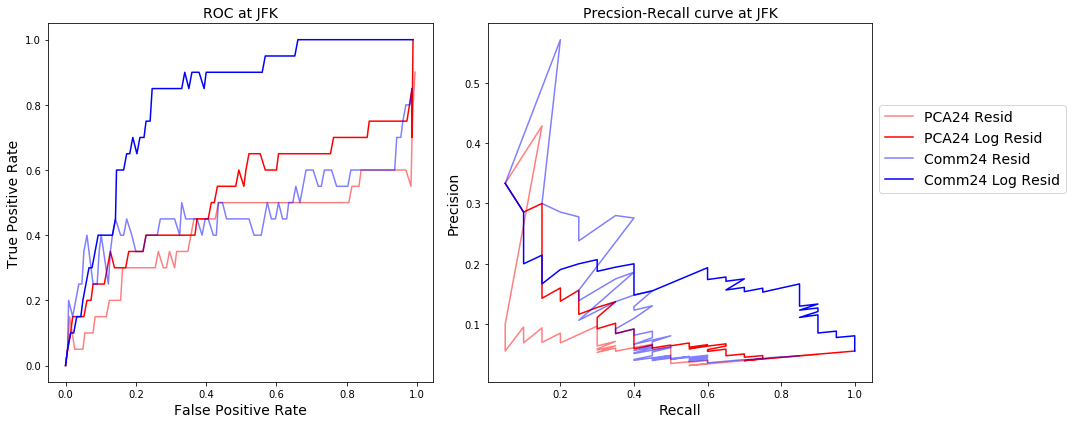

In [235]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1,2,figure=fig)
ax = fig.add_subplot(gs[0,0])
plotdf = record[record['station']=='JFK']
plotdf = plotdf.sort_values(['FPR'])
method = 'JFKPCA24RFCVResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['FPR'],plotdfgmm['TPR'],label='PCA24 Resid',color='r',alpha=0.5)

method = 'JFKPCA24RFCVLogResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['FPR'],plotdfgmm['TPR'],label='PCA24 Log Resid',color='r')

method = 'JFKComm24RFCVResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['FPR'],plotdfgmm['TPR'],label='Comm24 Resid',color='b',alpha=0.5)

method = 'JFKComm24RFCVLogResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['FPR'],plotdfgmm['TPR'],label='Comm24 Log Resid',color='b')


ax.set_title('ROC at JFK', fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)


ax = fig.add_subplot(gs[0,1])
plotdf = record[record['station']=='JFK']
# plotdf = plotdf.sort_values(['recall'])
method = 'JFKPCA24RFCVResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['recall'],plotdfgmm['precision'],label='PCA24 Resid',color='r',alpha=0.5)

method = 'JFKPCA24RFCVLogResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['recall'],plotdfgmm['precision'],label='PCA24 Log Resid',color='r')

method = 'JFKComm24RFCVResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['recall'],plotdfgmm['precision'],label='Comm24 Resid',color='b',alpha=0.5)

method = 'JFKComm24RFCVLogResid'
plotdfgmm = plotdf[(plotdf['Method']==method)&(plotdf['GMM']==EWRdataBestComp[method])]
ax.plot(plotdfgmm['recall'],plotdfgmm['precision'],label='Comm24 Log Resid',color='b')


ax.set_title('Precsion-Recall curve at JFK', fontsize=14)
ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.65),fontsize=14)
plt.tight_layout()
plt.savefig('JFKROC-PC.png')

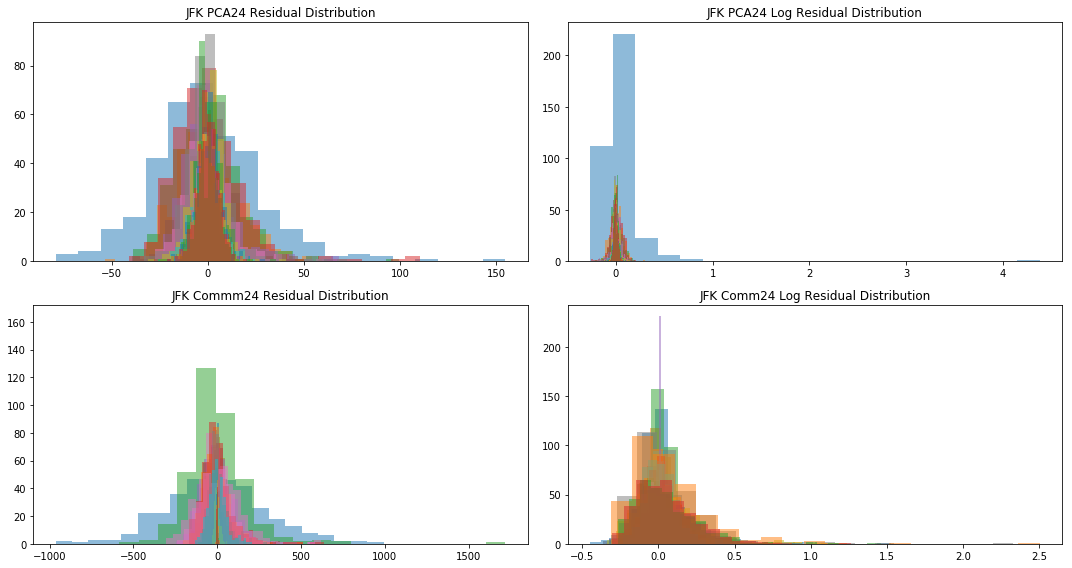

In [251]:
fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(2,2,figure=fig)

ax = fig.add_subplot(gs[0,0])
station = 'JFK'
filename = "GMMDataset/selected/RFCV/%sPCA24RFCVResidDailyAggregated.csv"%station
data = pd.read_csv(filename)
data = data.drop(columns=['date'])
for column in data.columns:
    plt.hist(data[column].values.tolist(),bins=20,alpha=0.5,label=column)
ax.set_title('JFK PCA24 Residual Distribution')
    
ax = fig.add_subplot(gs[0,1])
filename = "GMMDataset/selected/RFCV/%sPCA24RFCVLogResidDailyAggregated.csv"%station
data = pd.read_csv(filename)
data = data.drop(columns=['Date'])
for column in data.columns:
    plt.hist(data[column].values.tolist(),bins=20,alpha=0.5,label=column)
ax.set_title('JFK PCA24 Log Residual Distribution')

ax = fig.add_subplot(gs[1,0])
filename = "GMMDataset/selected/RFCV/%sComm24RFCVResidDailyAggregated.csv"%station
data = pd.read_csv(filename)
data = data.drop(columns=['date'])
for column in data.columns:
    plt.hist(data[column].values.tolist(),bins=20,alpha=0.5,label=column)
ax.set_title('JFK Commm24 Residual Distribution')
    
ax = fig.add_subplot(gs[1,1]) 
filename = "GMMDataset/selected/RFCV/%sComm24RFCVLogResidDailyAggregated.csv"%station
data = pd.read_csv(filename)
data = data.drop(columns=['Date'])
for column in data.columns:
    plt.hist(data[column].values.tolist(),bins=20,alpha=0.5,label=column)
ax.set_title('JFK Comm24 Log Residual Distribution')
plt.tight_layout()
plt.savefig('JFKResidDistribution.png')